<img src="flopylogo.png" style="float: left">

# Problem P4.6 Hubbertville Areal Model testing No-Flow BCs

In Problem P4.3 from page 172-174 in Anderson, Woessner and Hunt (2015), we are asked to construct an areal 2D model to assess impacts of pumping.  It is often tempting to define boundaries of an areally extensive aquifer using hydraulic no-flow boundary conditions placed at some distance from the area of interest. The two no-flow boundaries (streamlines) define a flow tube (or under special conditions, a stream tube; see Fig. B8.2.1 in Box 8.2). One way to determine if this boundary assignment will adversely affect the modeling results is to replace the no-flow boundaries with specified heads. If flow occurs to or from these specified head nodes, the assignment of noflow boundaries is not appropriate. This method can be illustrated using the Green Swamp problem. Let us assume that the Slate Mountains do not exist. Instead the no-flow boundaries define a 4500 m wide flow tube within a larger regional flow system.

## Part a.
Replace the no-flow boundaries that delineate the flow tube in P4.3a with specified heads taken from the solution of problem P4.3a. Run the model to check that it reproduces the steady-state heads of P4.3a. Calculate the east-west fluxes at the flow tube boundaries and the discharge to the Green Swamp. Be sure your modeled area is 4500 m wide.

<img src="P4.3_figure.tiff" style="float: center">

Below is an iPython Notebook that builds a Python MODFLOW model for this problem and plots results. See the Github readme.md file associated with this Chapter for information on one suggested installation and setup configuration for Python and iPython Notebook.

[Acknowledgements: This tutorial is modeled after example iPython Notebooks developed by Chris Langevin and Joe Hughes for the USGS Spring 2015 Python Training course GW1774.  All mistakes though are mine alone; if you prefer not to use the Github system, let me know any issues at rjhunt@facstaff.wisc.edu]

##Flopy Tutorial 1: Creating the Model (Similar to Problem P4.3a)
In this example, we will create a simple groundwater flow model by following the tutorial included on the Flopy website.  We will make a few small changes  so that the tutorial works with our file structure.

Visit the tutorial website [here](http://modflowpy.github.io/flopydoc/tutorial1.html "tutorial")."

###Setup the Notebook Environment and Import Flopy
Load a few standard libraries, and then load flopy.

In [1]:
%matplotlib inline
import sys
import os
import shutil
import numpy as np
from subprocess import check_output

# Import flopy
import flopy

###Setup a New Directory and Change Paths
For this tutorial, we will work in a new subdirectory underneath the directory where the notebook is located. We can use some fancy Python tools to help us manage the directory creation. Note that if you encounter path problems with this workbook, you can stop and then restart the kernel and the paths will be reset.

In [2]:
# Set the name of the path to the model working directory
dirname = "P4-6_Hubbertville"
datapath = os.getcwd()
modelpath = os.path.join(datapath, dirname)
print 'Name of model path: ', modelpath

# Now let's check if this directory exists.  If not, then we will create it.
if os.path.exists(modelpath):
    print 'Model working directory already exists.'
else:
    print 'Creating model working directory.'
    os.mkdir(modelpath)

Name of model path:  /Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-6_Hubbertville
Creating model working directory.


###Define the Model Extent, Grid Resolution, and Characteristics
It is normally good practice to group things that you might want to change into a single code block.  This makes it easier to make changes and rerun the code.

In [3]:
# model domain and grid definition
# The major difference between P4.3a and P4.6a is the handling of side perimeter BCs.  No-flow BCs are the
# default in MODFLOW so we did not need to include them at the perimeter of the grid.  However, specified head side 
# BCs need to be included in the grid in MODFLOW.  Therefore, we have to increase the width of the grid by one node
# on each end. We do this by making the width wider (2 x 500 m) and increase the number of columns 
LX = 5500.
LY = 11000.   # note that there is an added 500m on the top and bottom to represent the boundary conditions,that leaves an aqufier lenght of 10000 m  
ZTOP = 1030.  # the system is unconfined so set the top above land surface so that the water table never > layer top
ZBOT = 980.
NLAY = 1
NROW = 22
#here we increase the number of columns from 9 to 11 to account for the larger model domain width and 2 additional cells
NCOL = 11
DELR = LX / NCOL  # recall that MODFLOW convention is DELR is along a row, thus has items = NCOL; see page XXX in AW&H (2015)
DELC = LY / NROW  # recall that MODFLOW convention is DELC is along a column, thus has items = NROW; see page XXX in AW&H (2015)
DELV = (ZTOP - ZBOT) / NLAY
BOTM = np.linspace(ZTOP, ZBOT, NLAY + 1)
HK = 50.
VKA = 1.
RCH = 0.001
WELLQ = 0.   #recall MODFLOW convention, negative means pumped out of the model domain (=aquifer)
print "DELR =", DELR, "  DELC =", DELC, '  DELV =', DELV
print "BOTM =", BOTM
print "Recharge =", RCH 
print "Pumping well rate =", WELLQ


DELR = 500.0   DELC = 500.0   DELV = 50.0
BOTM = [ 1030.   980.]
Recharge = 0.001
Pumping well rate = 0.0


###Create the MODFLOW Model Object
Create a flopy MODFLOW object: [flopy.modflow.Modflow](http://modflowpy.github.io/flopydoc/mf.html).

In [4]:
# Assign name and create modflow model object
modelname = 'P4-6'
#exe_name = os.path.join(datapath, 'mf2005.exe') # for Windows OS
exe_name = os.path.join(datapath, 'mf2005')     # for Mac OS
print 'Model executable: ', exe_name
MF = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws=modelpath)

Model executable:  /Users/rjhunt1/GitHub/Chapter_4_problems-1/mf2005


###Discretization Package
Create a flopy discretization package object: [flopy.modflow.ModflowDis](http://modflowpy.github.io/flopydoc/mfdis.html).

In [5]:
# Create the discretization object
TOP = ZTOP * np.ones((NROW, NCOL),dtype=np.float)

In [6]:
DIS_PACKAGE = flopy.modflow.ModflowDis(MF, NLAY, NROW, NCOL, delr=DELR, delc=DELC,
                               top=TOP, botm=BOTM[1:], laycbd=0)
# print DIS_PACKAGE  #uncomment this on far left to see information about the flopy object

###Basic Package
Create a flopy basic package object: [flopy.modflow.ModflowBas](http://modflowpy.github.io/flopydoc/mfbas.html).

In [7]:
# Variables for the BAS package
IBOUND = np.ones((NLAY, NROW, NCOL), dtype=np.int32)  # all nodes are active (IBOUND = 1)
# Let's check and make sure that our 2 additional columns showed up in the right place and the
# model domain dimension is correct.
print IBOUND

[[[1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1 1 1 1]]]


In [8]:
# like P4.3a, make the top of the profile specified head by setting the IBOUND = -1
IBOUND[:, 0, :] = -1  #don't forget arrays are zero-based!
IBOUND[:, -1, :] = -1  #-1 is Python for last in array
# let's see recreate the implicit side no-flow BCs explicitly to match P4.3a
IBOUND[:, :, 0] = 0  #don't forget arrays are zero-based
IBOUND[:, :, -1] = 0  #-1 is Python for last in array
print IBOUND

[[[ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0  1  1  1  1  1  1  1  1  1  0]
  [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]]


In [9]:
STRT = 1015 * np.ones((NLAY, NROW, NCOL), dtype=np.float32)  # set starting head to 1010 m through out model domain
STRT[:, 0, :] = 1000.       # river stage for setting constant head
STRT[:, -1, :] = 1000.     # wetland stage for setting constant head
print STRT

[[[ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.
    1000.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.
    1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.
    1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.
    1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.
    1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.
    1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.
    1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.
    1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.
    1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.
    1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.
    1015.]
  [ 1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.  1015.
   

In [10]:
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)
# print BAS_PACKAGE  # uncomment this at far left to see the information about the flopy BAS object

###Layer Property Flow Package
Create a flopy layer property flow package object: [flopy.modflow.ModflowLpf](http://modflowpy.github.io/flopydoc/mflpf.html).

In [11]:
LPF_PACKAGE = flopy.modflow.ModflowLpf(MF, laytyp=1, hk=HK, vka=VKA)  # we defined the K and anisotropy at top of file
# print LPF_PACKAGE  # uncomment this at far left to see the information about the flopy LPF object

###Well Package
Create a flopy output control object: [flopy.modflow.ModflowWel](http://modflowpy.github.io/flopydoc/mfwel.html).

In [12]:
WEL_PACKAGE = flopy.modflow.ModflowWel(MF, stress_period_data=[0,4,5,WELLQ]) 
#note that we had to account for the additional column when compared to the location specified in P4.4

###Output Control
Create a flopy output control object: [flopy.modflow.ModflowOc](http://modflowpy.github.io/flopydoc/mfoc.html).

In [13]:
OC_PACKAGE = flopy.modflow.ModflowOc(MF)   # we'll use the defaults for the model output
# print OC_PACKAGE  # uncomment this at far left to see the information about the flopy OC object

###Preconditioned Conjugate Gradient Solver
Create a flopy pcg package object: [flopy.modflow.ModflowPcg](http://modflowpy.github.io/flopydoc/mfpcg.html).

In [14]:
PCG_PACKAGE = flopy.modflow.ModflowPcg(MF, mxiter=500, iter1=100, hclose=1e-04, rclose=1e-04, relax=0.98, damp=0.5) 
# print PCG_PACKAGE  # uncomment this at far left to see the information about the flopy PCG object

###Recharge Package
Create a flopy pcg package object: [flopy.modflow.ModflowRch](http://modflowpy.github.io/flopydoc/mfrch.html).

In [15]:
RCH_PACKAGE = flopy.modflow.ModflowRch(MF, rech=RCH)
# print RCH_PACKAGE  # uncomment this at far left to see the information about the flopy RCH object

##Flopy Tutorial 1: Writing the MODFLOW Input Files
Before we create the model input datasets, we can do some directory cleanup to make sure that we don't accidently use old files.

In [16]:
#Before writing input, destroy all files in folder to prevent reusing old files
#Here's the working directory
print modelpath
#Here's what's currently in the working directory
modelfiles = os.listdir(modelpath)
print modelfiles

/Users/rjhunt1/GitHub/Chapter_4_problems-1/P4-6_Hubbertville
[]


In [17]:
#delete these files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

In [18]:
#Now write the model input files
MF.write_input()

##Flopy Tutorial 1: Running the Model

Flopy has several methods attached to the model object that can be used to run the model.  They are run_model, run_model2, and run_model3.  Here we use run_model3, which will write output to the notebook.

In [19]:
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_4_problems-1/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P4-6.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/04/30 15:15:30

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/04/30 15:15:30
 Elapsed run time:  0.012 Seconds

  Normal termination of simulation


##Flopy Tutorial 1: Post Processing the Results
To read heads from the MODFLOW binary output file, we can use the [flopy.utils.binaryfile](http://modflowpy.github.io/flopydoc/binaryfile.html) module. Specifically, we can use the HeadFile object from that module to extract head data arrays. 

In [20]:
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

Headfile (P4-6.hds) contains the following list of times:  [1.0]


In [21]:
#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Head statistics
  min:  -999.99
  max:  1010.83
  std:  774.159


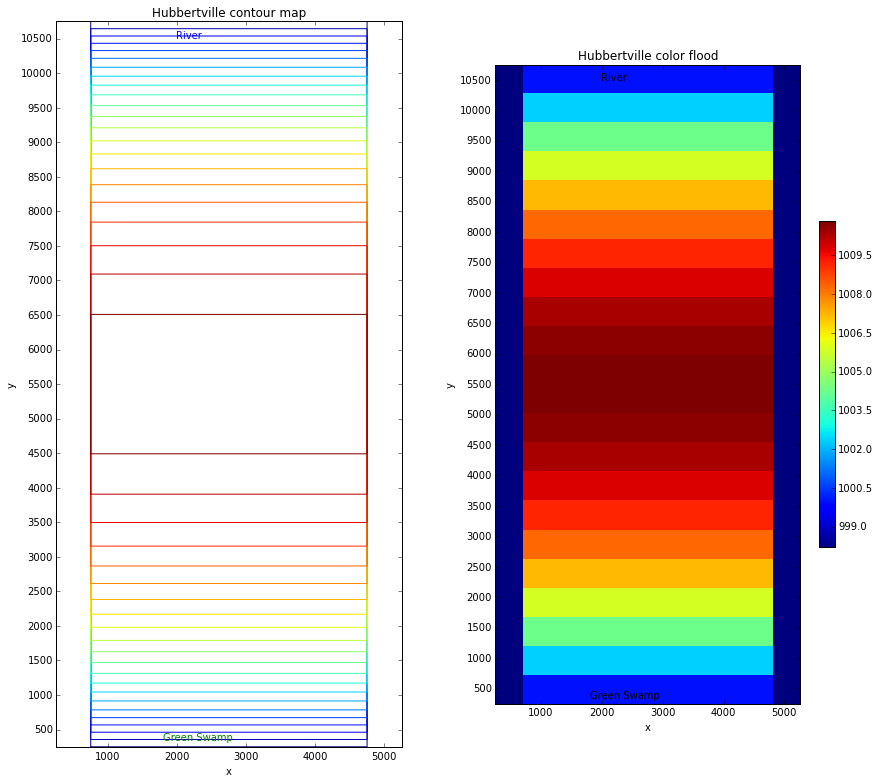

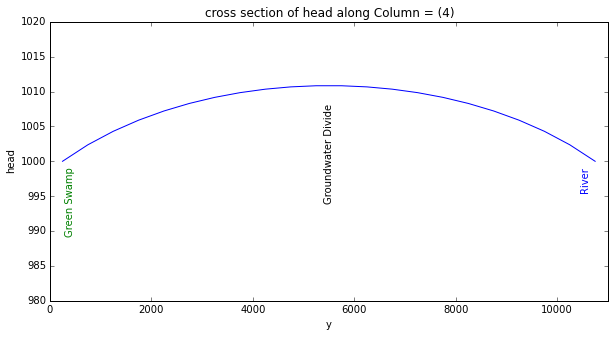

In [22]:
# the -999.99 value reflects the inactive (no-flow) BCs so can be ignored
#Create a contour plot of heads
FIG = plt.figure(figsize=(15,13))

#setup contour levels and plot extent
LEVELS = np.arange(1000., 1011., 0.5)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 11000, 500)
AX1.set_yticks(YTICKS)
AX1.set_title("Hubbertville contour map")
AX1.text(2000, 10500, r"River", fontsize=10, color="blue")
AX1.text(1800, 340, r"Green Swamp", fontsize=10, color="green")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("Hubbertville color flood")
AX2.text(2000, 10500, r"River", fontsize=10, color="black")
AX2.text(1800, 340, r"Green Swamp", fontsize=10, color="black")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest', vmin=998.2)
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)

#as before let's plot a north-south cross section
COL = 4
# recall we need to flip because MODFLOW's array does not = Python, so we reverse the order (flip them) and call it 
Y = np.flipud(HEAD[0,:,COL])
#for our cross section create X-coordinates to match with heads
XCOORD = np.arange(0, 11000, 500) + 250
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  'cross section of head along Column = ({0})'.format(COL)
ax.set_title(TITLE)
ax.set_xlabel('y')
ax.set_ylabel('head')
ax.set_xlim(0, 11000.)
ax.set_ylim(980.,1020.)
ax.text(10480, 998, r"River", fontsize=10, color="blue",rotation='vertical')
ax.text(300, 998, r"Green Swamp", fontsize=10, color="green",rotation='vertical')
ax.text(5400,1007., r"Groundwater Divide", fontsize=10, color="black",rotation='vertical')
ax.plot(XCOORD, Y)

In [23]:
#calculate the flux to Green Swamp
HEAD_ADJACENT_CELLS = HEAD[0,-2,1:10] # we do not include the side perimeter no flow cells
print "heads in cells next to Green Swamp =", HEAD_ADJACENT_CELLS
print ""
FLUX_TO_SWAMP_EXPLICIT_NOFLOW = 0
THICK = (HEAD[0,-2,5]+1000.)/2 - ZBOT   #the thickness is approximated using the average saturated thickness
for NODEHEAD in HEAD_ADJACENT_CELLS:
    NODEFLUX = (HK * ((NODEHEAD-1000.)/(DELC)) * (DELR * THICK)) # Q = KIA
    FLUX_TO_SWAMP_EXPLICIT_NOFLOW += NODEFLUX
    print 'gradient =', (NODEHEAD-1000)/(DELC), '  Kh =', HK, '  thickness=', THICK, ' Grid spacing =', DELC, ' Node flux =', NODEFLUX
print ""
print "Total Flux to Swamp Explicit No-flow BCs =", FLUX_TO_SWAMP_EXPLICIT_NOFLOW, "cubic meters per day"

heads in cells next to Green Swamp = [ 1002.36767578  1002.36767578  1002.36767578  1002.36767578  1002.36767578
  1002.36767578  1002.36767578  1002.36767578  1002.36767578]

gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.004735

Checking back to P4.3a shows this is a similar result, and the aquifer width is still 4500 m. Now let's change the perimeter no-flow BCs to specified head.

In [24]:
#In order to replace the no-flow BCs with specified head we'll need the Col 2 and Col 10 heads from headobj
#Extract HEAD along a column
MODFLOW_COL_2_HEADS = HEAD[0,:,1]  # recall Python uses zero indexing so MODFLOW's Col 1 = Python's Col 0
MODFLOW_COL_10_HEADS = HEAD[0,:,-2]  # Likewise, Python's zero indexing means MODFLOW's Col 10 = Python's Col 9
print "MODFLOW Column 2 Heads:"
print MODFLOW_COL_2_HEADS
print "MODFLOW Column 10 Heads:"
print MODFLOW_COL_10_HEADS

MODFLOW Column 2 Heads:
[ 1000.          1002.36767578  1004.29956055  1005.8949585   1007.21380615
  1008.29510498  1009.16546631  1009.84344482  1010.34191895  1010.66973877
  1010.83233643  1010.83233643  1010.66973877  1010.34191895  1009.84344482
  1009.16546631  1008.29510498  1007.21380615  1005.8949585   1004.29956055
  1002.36767578  1000.        ]
MODFLOW Column 10 Heads:
[ 1000.          1002.36767578  1004.29956055  1005.8949585   1007.21380615
  1008.29510498  1009.16546631  1009.84344482  1010.34191895  1010.66973877
  1010.83233643  1010.83233643  1010.66973877  1010.34191895  1009.84344482
  1009.16546631  1008.29510498  1007.21380615  1005.8949585   1004.29956055
  1002.36767578  1000.        ]


In [25]:
# we see that the problem has symmetry so MODFLOW's Col 2 heads = Col 9 heads., which agrees with the plot  
# Recall though that MODFLOW's array structure does not = Python, and the Flopy tool is 
# Python consistent, so we need to reverse the order that came from the MODFLOW head file (flip them).
# It is not really needed here because of the problem dimension/symmetry, but it is good practice so we'll flip them
print "Python Column 1 Heads:"
PYTHON_COL_1_HEADS = np.flipud(MODFLOW_COL_2_HEADS)
print PYTHON_COL_1_HEADS
print "Python Column 9 Heads:"
PYTHON_COL_9_HEADS = np.flipud(MODFLOW_COL_10_HEADS)
print PYTHON_COL_9_HEADS

Python Column 1 Heads:
[ 1000.          1002.36767578  1004.29956055  1005.8949585   1007.21380615
  1008.29510498  1009.16546631  1009.84344482  1010.34191895  1010.66973877
  1010.83233643  1010.83233643  1010.66973877  1010.34191895  1009.84344482
  1009.16546631  1008.29510498  1007.21380615  1005.8949585   1004.29956055
  1002.36767578  1000.        ]
Python Column 9 Heads:
[ 1000.          1002.36767578  1004.29956055  1005.8949585   1007.21380615
  1008.29510498  1009.16546631  1009.84344482  1010.34191895  1010.66973877
  1010.83233643  1010.83233643  1010.66973877  1010.34191895  1009.84344482
  1009.16546631  1008.29510498  1007.21380615  1005.8949585   1004.29956055
  1002.36767578  1000.        ]


In [26]:
#Now let's reformulate the IBOUND array to change side no-flow perimeter BCs to specified head
IBOUND[:, :, 0] = -1  #don't forget arrays are zero-based
IBOUND[:, :, -1] = -1  #-1 in the list is Python for last in array
print IBOUND

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1 -1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]]


In [27]:
#Recall that MODFLOW uses starting head values to set specified head BCs, so we need to update the 
#starting head array. 
STRT[:, :, 0] = PYTHON_COL_1_HEADS      # set column 0 heads to the simulated heads from column 1
STRT[:, :, -1] = PYTHON_COL_9_HEADS     # likewise, set column 10 heads to the simulated heads from column 9
print STRT

[[[ 1000.          1000.          1000.          1000.          1000.
    1000.          1000.          1000.          1000.          1000.
    1000.        ]
  [ 1002.36767578  1015.          1015.          1015.          1015.
    1015.          1015.          1015.          1015.          1015.
    1002.36767578]
  [ 1004.29956055  1015.          1015.          1015.          1015.
    1015.          1015.          1015.          1015.          1015.
    1004.29956055]
  [ 1005.8949585   1015.          1015.          1015.          1015.
    1015.          1015.          1015.          1015.          1015.
    1005.8949585 ]
  [ 1007.21380615  1015.          1015.          1015.          1015.
    1015.          1015.          1015.          1015.          1015.
    1007.21380615]
  [ 1008.29510498  1015.          1015.          1015.          1015.
    1015.          1015.          1015.          1015.          1015.
    1008.29510498]
  [ 1009.16546631  1015.          1015.       

In [28]:
#now we have to update MODFLOW's BAS Package for this new information
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)
#and delete the old MODFLOW input files 
#delete these files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
Deleted:  P4-6.bas
Deleted:  P4-6.cbc
Deleted:  P4-6.ddn
Deleted:  P4-6.dis
Deleted:  P4-6.hds
Deleted:  P4-6.list
Deleted:  P4-6.lpf
Deleted:  P4-6.nam
Deleted:  P4-6.oc
Deleted:  P4-6.pcg
Deleted:  P4-6.rch
Deleted:  P4-6.wel


In [29]:
# and write the new MODFLOW input
MF.write_input()
# and re-run MODFLOW-2005
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_4_problems-1/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P4-6.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/04/30 15:15:32

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/04/30 15:15:32
 Elapsed run time:  0.006 Seconds

  Normal termination of simulation


In [30]:
# and check head statistics
#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Headfile (P4-6.hds) contains the following list of times:  [1.0]
Head statistics
  min:  1000.0
  max:  1010.83
  std:  3.47


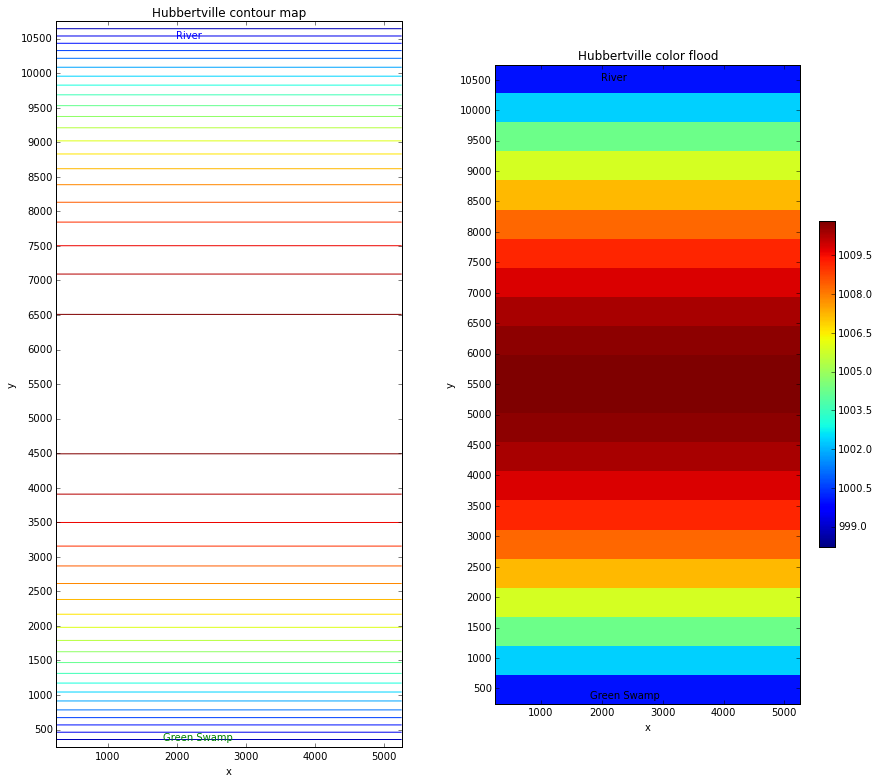

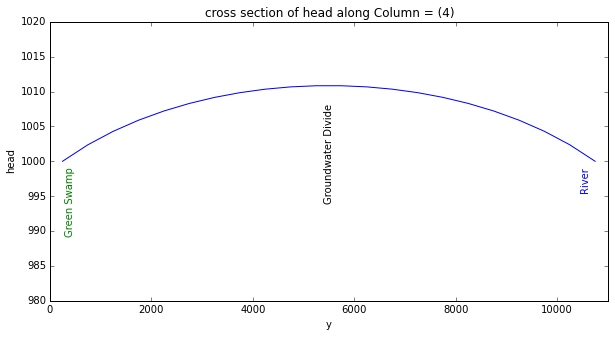

In [31]:
# plot to have a visual comparison too
#Create a contour plot of heads
FIG = plt.figure(figsize=(15,13))

#setup contour levels and plot extent
LEVELS = np.arange(1000., 1011., 0.5)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 11000, 500)
AX1.set_yticks(YTICKS)
AX1.set_title("Hubbertville contour map")
AX1.text(2000, 10500, r"River", fontsize=10, color="blue")
AX1.text(1800, 340, r"Green Swamp", fontsize=10, color="green")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("Hubbertville color flood")
AX2.text(2000, 10500, r"River", fontsize=10, color="black")
AX2.text(1800, 340, r"Green Swamp", fontsize=10, color="black")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest', vmin=998.2)
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)

#as before let's plot a north-south cross section
COL = 4
# recall we need to flip because MODFLOW's array does not = Python, so we reverse the order (flip them) and call it 
Y = np.flipud(HEAD[0,:,COL])
#for our cross section create X-coordinates to match with heads
XCOORD = np.arange(0, 11000, 500) + 250
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  'cross section of head along Column = ({0})'.format(COL)
ax.set_title(TITLE)
ax.set_xlabel('y')
ax.set_ylabel('head')
ax.set_xlim(0, 11000.)
ax.set_ylim(980.,1020.)
ax.text(10480, 998, r"River", fontsize=10, color="blue",rotation='vertical')
ax.text(300, 998, r"Green Swamp", fontsize=10, color="green",rotation='vertical')
ax.text(5400,1007., r"Groundwater Divide", fontsize=10, color="black",rotation='vertical')
ax.plot(XCOORD, Y)

In [32]:
#looks the same as P4.3a.  
#but let's check using the flux to Green Swamp
HEAD_ADJACENT_CELLS = HEAD[0,-2,1:10] # we do not include the side perimeter no flow cells
print "heads in cells next to Green Swamp =", HEAD_ADJACENT_CELLS
print ""
FLUX_TO_SWAMP_SPEC_HEAD = 0
THICK = (HEAD[0,-2,5]+1000.)/2 - ZBOT   #the thickness is approximated using the average saturated thickness
for NODEHEAD in HEAD_ADJACENT_CELLS:
    NODEFLUX = (HK * ((NODEHEAD-1000.)/(DELC)) * (DELR * THICK)) # Q = KIA
    FLUX_TO_SWAMP_SPEC_HEAD += NODEFLUX
    print 'gradient =', (NODEHEAD-1000)/(DELC), '  Kh =', HK, '  thickness=', THICK, ' Grid spacing =', DELC, ' Node flux =', NODEFLUX
print ""
print "Total Flux to Swamp Specified Head perimeter BCs =", FLUX_TO_SWAMP_SPEC_HEAD, "cubic meters per day"

heads in cells next to Green Swamp = [ 1002.36779785  1002.36773682  1002.36773682  1002.36767578  1002.36767578
  1002.36767578  1002.36773682  1002.36773682  1002.36779785]

gradient = 0.00473559570312   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.95229226
gradient = 0.00473547363281   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.88764432
gradient = 0.00473547363281   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.88764432
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.0047353515625   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.82299638
gradient = 0.00473547363281   Kh = 50.0   thickness= 21.1838378906  Grid spacing = 500.0  Node flux = 2507.88764432
gradient = 0.00

In [33]:
# how about the same calculation with respect to the side perimeter BCs, left side first
HEAD_AT_LEFT_SPEC_HEAD_CELLS = HEAD[0,:,0]
HEAD_ADJACENT_CELLS = HEAD[0,:,1]
print "heads in cells next to left perimeter BC =", HEAD_ADJACENT_CELLS
print "heads in left perimeter BC =", HEAD_AT_LEFT_SPEC_HEAD_CELLS

heads in cells next to left perimeter BC = [ 1000.          1002.36779785  1004.29974365  1005.89501953  1007.21386719
  1008.29498291  1009.16522217  1009.84320068  1010.34185791  1010.66973877
  1010.83215332  1010.83215332  1010.66973877  1010.34185791  1009.84320068
  1009.16522217  1008.29498291  1007.21386719  1005.89501953  1004.29974365
  1002.36779785  1000.        ]
heads in left perimeter BC = [ 1000.          1002.36798096  1004.29998779  1005.89501953  1007.21398926
  1008.29498291  1009.16497803  1009.84301758  1010.34197998  1010.66998291
  1010.83197021  1010.83197021  1010.66998291  1010.34197998  1009.84301758
  1009.16497803  1008.29498291  1007.21398926  1005.89501953  1004.29998779
  1002.36798096  1000.        ]


In [34]:
# heads are almost exactly the same, therefore their difference is near 0, and 0 head difference = no flow
# let's check the right side too
HEAD_AT_RIGHT_SPEC_HEAD_CELLS = HEAD[0,:,-1]
HEAD_ADJACENT_CELLS = HEAD[0,:,-2]
print "heads in cells next to right perimeter BC =", HEAD_ADJACENT_CELLS
print "heads in right perimeter BC =", HEAD_AT_RIGHT_SPEC_HEAD_CELLS

heads in cells next to right perimeter BC = [ 1000.          1002.36779785  1004.29974365  1005.89501953  1007.21386719
  1008.29498291  1009.16522217  1009.84320068  1010.34185791  1010.66973877
  1010.83215332  1010.83215332  1010.66973877  1010.34185791  1009.84320068
  1009.16522217  1008.29498291  1007.21386719  1005.89501953  1004.29974365
  1002.36779785  1000.        ]
heads in right perimeter BC = [ 1000.          1002.36798096  1004.29998779  1005.89501953  1007.21398926
  1008.29498291  1009.16497803  1009.84301758  1010.34197998  1010.66998291
  1010.83197021  1010.83197021  1010.66998291  1010.34197998  1009.84301758
  1009.16497803  1008.29498291  1007.21398926  1005.89501953  1004.29998779
  1002.36798096  1000.        ]


##Testing your Skills

1.  Why isn't the gradient at the head-specified no-flow exactly zero?  Do you see this inequality expressed in the MODFLOW list file?

2.  MODFLOW here is using an iterative solver; how could we make the heads difference zero? 

#P4.6 Part b.

Simulate the steady-state flow field with the pumping well using the specified head boundaries that define the flow tube. Examine flow to and from the specified head boundaries and compare them to the prepumping rates calculated in
part (a). What is the discharge to Green Swamp? Are the hydraulic boundaries that define the flow tube sufficiently removed from the pumping well so that they act as no-flow boundaries? In other words is the flow to and from the specified head nodes along the flow tube boundaries sufficiently small so that there is effectively no flow from the side boundaries into the model domain under pumping conditions?

In [35]:
#We included the well above in Part a but assigned it a pumping rate of zero.  Recall from P4.4
#the pumping rate is 20,000 cubic meters per day. 
WELLQ = -20000.   #recall MODFLOW convention, negative means pumped out of the model domain (=aquifer)
print "Pumping well rate =", WELLQ

Pumping well rate = -20000.0


In [36]:
#update MODFLOW's WEL Package to include the new pumping rate
WEL_PACKAGE = flopy.modflow.ModflowWel(MF, stress_period_data=[0,4,5,WELLQ])
#note that we had to account for the additional column when compared to the location specified in P4.4

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...


In [37]:
#delete old MODFLOW input files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

Deleted:  P4-6.bas
Deleted:  P4-6.cbc
Deleted:  P4-6.ddn
Deleted:  P4-6.dis
Deleted:  P4-6.hds
Deleted:  P4-6.list
Deleted:  P4-6.lpf
Deleted:  P4-6.nam
Deleted:  P4-6.oc
Deleted:  P4-6.pcg
Deleted:  P4-6.rch
Deleted:  P4-6.wel


In [38]:
# and write the new MODFLOW input
MF.write_input()
# and re-run MODFLOW-2005
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_4_problems-1/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P4-6.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/04/30 15:15:34

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/04/30 15:15:34
 Elapsed run time:  0.008 Seconds

  Normal termination of simulation


In [39]:
# and check head statistics
#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Headfile (P4-6.hds) contains the following list of times:  [1.0]
Head statistics
  min:  997.795
  max:  1010.83
  std:  3.55032


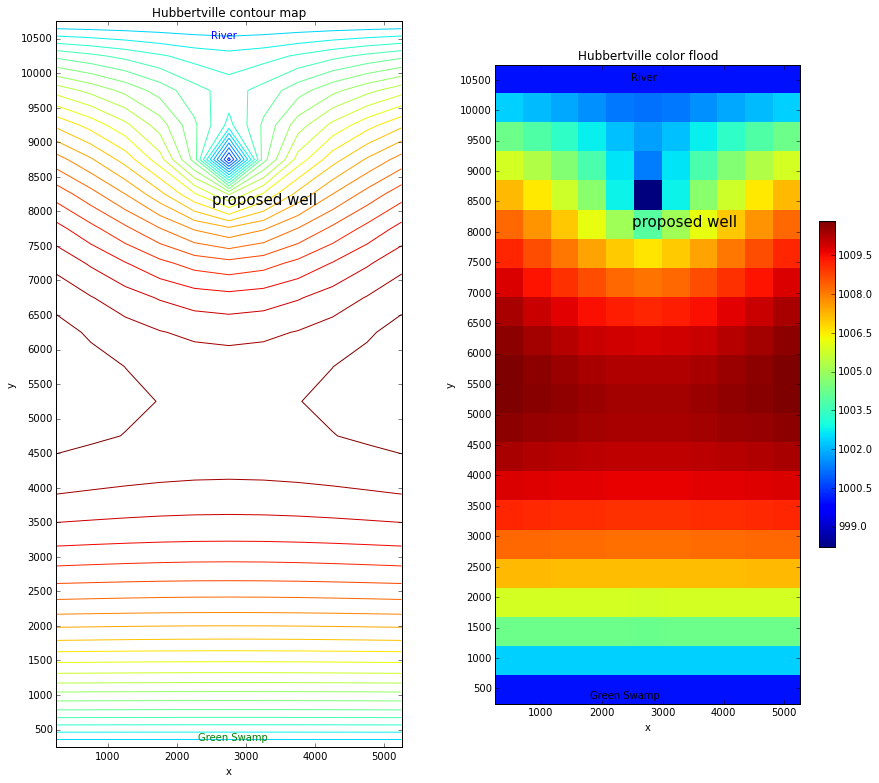

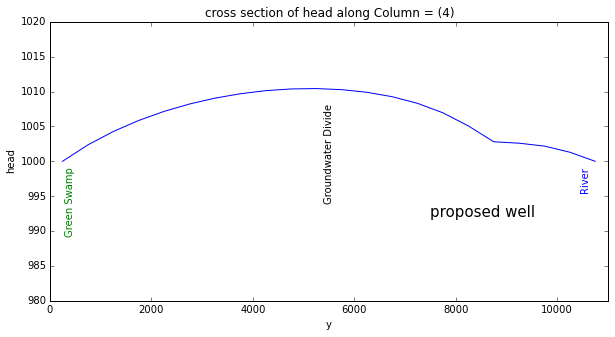

In [40]:
# plot to have a visual comparison too
#Create a contour plot of heads
FIG = plt.figure(figsize=(15,13))

#setup contour levels and plot extent
LEVELS = np.arange(995.5, 1011., 0.5)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 11000, 500)
AX1.set_yticks(YTICKS)
AX1.set_title("Hubbertville contour map")
AX1.text(2500, 10500, r"River", fontsize=10, color="blue")
AX1.text(2500, 8100, r"proposed well", fontsize=15, color="black")
AX1.text(2300, 340, r"Green Swamp", fontsize=10, color="green")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("Hubbertville color flood")
AX2.text(2500, 8100, r"proposed well", fontsize=15, color="black")
AX2.text(2500, 10500, r"River", fontsize=10, color="black")
AX2.text(1800, 340, r"Green Swamp", fontsize=10, color="black")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest', vmin=998.2)
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)

#as before let's plot a north-south cross section
COL = 4
# recall we need to flip because MODFLOW's array does not = Python, so we reverse the order (flip them) and call it 
Y = np.flipud(HEAD[0,:,COL])
#for our cross section create X-coordinates to match with heads
XCOORD = np.arange(0, 11000, 500) + 250
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  'cross section of head along Column = ({0})'.format(COL)
ax.set_title(TITLE)
ax.set_xlabel('y')
ax.set_ylabel('head')
ax.set_xlim(0, 11000.)
ax.set_ylim(980.,1020.)
ax.text(7500, 992, r"proposed well", fontsize=15, color="black")
ax.text(10480, 998, r"River", fontsize=10, color="blue",rotation='vertical')
ax.text(300, 998, r"Green Swamp", fontsize=10, color="green",rotation='vertical')
ax.text(5400,1007., r"Groundwater Divide", fontsize=10, color="black",rotation='vertical')
ax.plot(XCOORD, Y)

In [41]:
# Is there now a gradient between side perimeter BCs and the model domain, left side first
HEAD_AT_LEFT_SPEC_HEAD_CELLS = HEAD[0,:,0]
HEAD_ADJACENT_CELLS = HEAD[0,:,1]
print "heads in cells next to left perimeter BC =", HEAD_ADJACENT_CELLS
print "heads in left perimeter BC =", HEAD_AT_LEFT_SPEC_HEAD_CELLS
# let's check the right side too
HEAD_AT_RIGHT_SPEC_HEAD_CELLS = HEAD[0,:,-1]
HEAD_ADJACENT_CELLS = HEAD[0,:,-2]
print "heads in cells next to right perimeter BC =", HEAD_ADJACENT_CELLS
print "heads in right perimeter BC =", HEAD_AT_RIGHT_SPEC_HEAD_CELLS

heads in cells next to left perimeter BC = [ 1000.          1002.11834717  1003.85247803  1005.30712891  1006.56713867
  1007.6875      1008.65155029  1009.43560791  1010.02990723  1010.43566895
  1010.65826416  1010.70349121  1010.57452393  1010.2713623   1009.79095459
  1009.12646484  1008.26629639  1007.19287109  1005.88012695  1004.28991699
  1002.36273193  1000.        ]
heads in left perimeter BC = [ 1000.          1002.36798096  1004.29998779  1005.89501953  1007.21398926
  1008.29498291  1009.16497803  1009.84301758  1010.34197998  1010.66998291
  1010.83197021  1010.83197021  1010.66998291  1010.34197998  1009.84301758
  1009.16497803  1008.29498291  1007.21398926  1005.89501953  1004.29998779
  1002.36798096  1000.        ]
heads in cells next to right perimeter BC = [ 1000.          1002.11834717  1003.85247803  1005.30712891  1006.56713867
  1007.6875      1008.65155029  1009.43560791  1010.02990723  1010.43566895
  1010.65826416  1010.70349121  1010.57452393  1010.2713623 

In [42]:
# These are decidedly not the same, therefore there is a gradient across our "no-flow" boundary.   
# let's check using the flux to Green Swamp
HEAD_ADJACENT_CELLS = HEAD[0,-2,1:10] # we do not include the side perimeter no flow cells
print "heads in cells next to Green Swamp =", HEAD_ADJACENT_CELLS
FLUX_TO_SWAMP_PUMPING_SPEC_HEAD = 0
THICK = (HEAD[0,-2,5]+1000.)/2 - ZBOT   #the thickness is approximated using the average saturated thickness
for NODEHEAD in HEAD_ADJACENT_CELLS:
    NODEFLUX = (HK * ((NODEHEAD-1000.)/(DELC)) * (DELR * THICK)) # Q = KIA
    FLUX_TO_SWAMP_PUMPING_SPEC_HEAD += NODEFLUX
    print 'gradient =', (NODEHEAD-1000)/(DELC), '  Kh =', HK, '  thickness=', THICK, ' Grid spacing =', DELC, ' Node flux =', NODEFLUX
print ""    
print "Total Flux to Swamp: Pumping with Specified Head Perimeter BCs =", FLUX_TO_SWAMP_PUMPING_SPEC_HEAD, "cubic meters per day"

heads in cells next to Green Swamp = [ 1002.36273193  1002.35809326  1002.35437012  1002.35205078  1002.35119629
  1002.35205078  1002.35437012  1002.35809326  1002.36273193]
gradient = 0.00472546386719   Kh = 50.0   thickness= 21.1755981445  Grid spacing = 500.0  Node flux = 2501.61309745
gradient = 0.00471618652344   Kh = 50.0   thickness= 21.1755981445  Grid spacing = 500.0  Node flux = 2496.70176487
gradient = 0.00470874023437   Kh = 50.0   thickness= 21.1755981445  Grid spacing = 500.0  Node flux = 2492.75977425
gradient = 0.0047041015625   Kh = 50.0   thickness= 21.1755981445  Grid spacing = 500.0  Node flux = 2490.30410796
gradient = 0.00470239257812   Kh = 50.0   thickness= 21.1755981445  Grid spacing = 500.0  Node flux = 2489.39938881
gradient = 0.0047041015625   Kh = 50.0   thickness= 21.1755981445  Grid spacing = 500.0  Node flux = 2490.30410796
gradient = 0.00470874023437   Kh = 50.0   thickness= 21.1755981445  Grid spacing = 500.0  Node flux = 2492.75977425
gradient = 0.00

In [43]:
#let's compare the different perimeter BC formulations:  
print "P4.3 Flux to Swamp (no pumping/implicit no-flow perimeter BCs) =", 22570
print "P4.6a Flux to Swamp (no pumping/explicit no-flow perimeter BCs) =", FLUX_TO_SWAMP_EXPLICIT_NOFLOW
print "P4.6a Flux to Swamp (no pumping/specified head perimeter BCs) =", FLUX_TO_SWAMP_SPEC_HEAD
print "P4.6b Flux to Swamp (pumping/specified head perimeter BCs) =", FLUX_TO_SWAMP_PUMPING_SPEC_HEAD
print ''
print "Actual Flux to Swamp with pumping from P4.4 =", 17884, "cubic meters per day"

P4.3 Flux to Swamp (no pumping/implicit no-flow perimeter BCs) = 22570
P4.6a Flux to Swamp (no pumping/explicit no-flow perimeter BCs) = 22570.4069674
P4.6a Flux to Swamp (no pumping/specified head perimeter BCs) = 22570.9241509
P4.6b Flux to Swamp (pumping/specified head perimeter BCs) = 22452.1568779

Actual Flux to Swamp with pumping from P4.4 = 17884 cubic meters per day


Does the contour plot provide early insight into these results (hint: compare contours near the perimeter BCs)?